In [1]:
# Adrian Marinovich
# Springboard - Data Science Career Track 
# Capston Project #1 - Smiles dataset
# Data wrangling

In [1]:
# Given the size of the datasets (45MB for grayscale, 145MB for 3-color), and
#  anticipating I may import additional data to further pursue facial expression
#  analysis, I decided to store data on the Amazon Web Services (AWS) S3 bucket,
#  and to use an instance of AWS Deep Learning AMI (Amazon Machine Image), which
#  allows scaling to higher performance processors as needed.
#
#  Here, among other packages, I import Boto (boto3), the AWS SDK for Python, 
#   then use Boto tools to pull the data from the SWA S3 bucket into this 
#   Jupyter notebook, which is running on an AWS EC2 instance.

import boto3
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import re
import shutil

s3 = boto3.resource('s3')
client = boto3.client('s3')
resource = boto3.resource('s3')

# The S3 buckets already created, hold:
#   All 13233 LFWcrop images in adriatic13s1, obtained from:
#     http://conradsanderson.id.au/lfwcrop/
#   The smile and non-smile lists in adriatic13s2, obtained from:
#     https://data.mendeley.com/datasets/yz4v8tb3tp/5
#
# Note that the following commented commands must be run in a local 
#   terminal (linux, with AWS CLI already installed) in order to 
#   create and fill the S3 buckets described in part above.
#
#aws s3 mb s3://adriatic13 --profile adrian_iam_2
#
#aws s3 ls --profile adrian_iam_2
#
#aws s3 mb s3://adriatic13s1 --profile adrian_iam_2
#
#aws s3 cp "/home/adrian/awork/ds/cvision/smiles/faces" s3://adriatic13s1 --recursive --profile adrian_iam_2
#
#aws s3 mb s3://adriatic13s2 --profile adrian_iam_2
#
#aws s3 cp "/home/adrian/awork/ds/cvision/smiles/smile_lists" s3://adriatic13s2 --recursive --profile adrian_iam_2


In [14]:
# View the S3 buckets
for bucket in s3.buckets.all():
    print(bucket.name)

adriatic13
adriatic13s1
adriatic13s2


In [15]:
# Access, count and view named files in cropped images bucket,
#  and print first and last image file names and count numbers
count=0
for obj in s3.Bucket(name='adriatic13s1').objects.all():
    count+=1
    if count==1:
        print(os.path.join(obj.bucket_name, obj.key), count)
print(os.path.join(obj.bucket_name, obj.key), count) 

adriatic13s1/AJ_Cook_0001.pgm 1
adriatic13s1/Zydrunas_Ilgauskas_0001.pgm 13233


In [16]:
# Access, count and view named files lists of labelled images bucket
count=0
for obj in s3.Bucket(name='adriatic13s2').objects.all():
    count+=1
    print(os.path.join(obj.bucket_name, obj.key), count) 

adriatic13s2/.directory 1
adriatic13s2/NON-SMILE_list.txt 2
adriatic13s2/SMILE_list.txt 3


In [17]:
# Create smile dict and smile pandas dataframe
smile_d = client.get_object(Bucket='adriatic13s2', Key='SMILE_list.txt')
smile_df = pd.read_csv(smile_d['Body'], header=None)

In [18]:
# View first 5 file names
smile_df.head(5)

0
0      James_Jones_0001.jpg
1      James_Kelly_0009.jpg
2  James_McPherson_0001.jpg
3       James_Watt_0001.jpg
4      Jamie_Carey_0001.jpg

In [19]:
# Create non-smile dict and non-smile pandas dataframe
nosmile_d = client.get_object(Bucket='adriatic13s2', Key='NON-SMILE_list.txt')
nosmile_df = pd.read_csv(nosmile_d['Body'], header=None)

In [20]:
# View first 5 file names
nosmile_df.head(5)

0
0        Aaron_Eckhart_0001.jpg
1      Aaron_Patterson_0001.jpg
2  Abdel_Nasser_Assidi_0002.jpg
3       Abdoulaye_Wade_0004.jpg
4    Abdulaziz_Kamilov_0001.jpg

In [21]:
# Create smile and non-smile lists from the dataframes, 
#  and check number of listings
smile_list = smile_df[0].tolist()
nosmile_list = nosmile_df[0].tolist()
print("Smile files:", len(smile_list), "\n", 
     "Non-smile files:", len(nosmile_list))

Smile files: 602 
 Non-smile files: 603


In [22]:
# Use list of smile image file names to select the corresponding 
#  images from the larger LFWcrop dataset of images
#
# Note: the smiles/ directory created will hold both smile and 
#  non-smile files together

os.makedirs('smiles/', exist_ok=True)

bucket1 = resource.Bucket('adriatic13s1')

objs = [os.path.join(obj.key) 
        for obj in s3.Bucket(name='adriatic13s1').objects.all()]
    
count = 0
for obj2 in objs:
    for name in smile_list:
        if obj2[:-4] == name[:-4]:
            count+=1
            bucket1.download_file(obj2, 'smiles/ysmile%d' % count)
print("Total smile matches downloaded:", count)

Total smile matches downloaded: 600


In [23]:
# Note that 2 file names in the smiles list did not 
#  appear to have an image match in LFWcrop.
#
# View these two non-matching file names

smile_names = [s[:-4] for s in smile_list]
objs_names = [o[:-4] for o in objs]

smile_no_match = [i for i in smile_names if i not in objs_names]
print(smile_no_match)

['listt', 'SMILE_list']


In [24]:
# View complete file names of these non-matches
print([s for s in smile_list if s[:-4] in smile_no_match])

#  Note: the output shows these are not image file names.
#   These file names can therefore be ignored.

['listt.txt', 'SMILE_list.txt']


In [25]:
# Use list of non-smile image file names to select the corresponding 
#  images from the larger LFWcrop dataset of images
bucket1 = resource.Bucket('adriatic13s1')

objs = [os.path.join(obj.key) 
        for obj in s3.Bucket(name='adriatic13s1').objects.all()]

count = 0
for obj2 in objs:
    for name in nosmile_list:
        if obj2[:-4] == name[:-4]:
            count+=1
            bucket1.download_file(obj2, 'smiles/nsmile%d' % count)
print("total matches downloaded:", count)

total matches downloaded: 603


AxesImage(54,36;334.8x217.44)


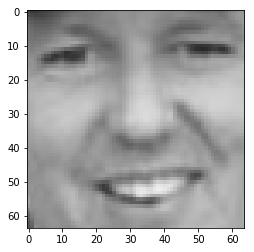

In [26]:
# View two images labelled smile and non-smile, 
#  and check pixel dimensions

imagePath1 = 'smiles/ysmile85'
imagePath2 = 'smiles/nsmile85'

imagey = cv2.imread(imagePath1)
imagen = cv2.imread(imagePath2)

print(plt.imshow(imagey))

AxesImage(54,36;334.8x217.44)


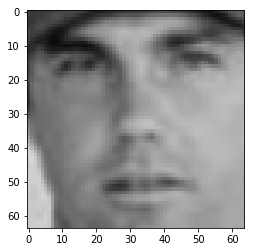

In [27]:
print(plt.imshow(imagen))

In [28]:
img = cv2.imread('smiles/ysmile85')
img.shape

(64, 64, 3)

In [29]:
# Note that, even though these are grayscale images, they
#  have each pixel's intensity in triplicate, as 
#  confirmed here
px = img[25,25]
print(px)

[172 172 172]


In [30]:
# Here we confirm that reducing the dimension of the array
#  will retain the grayscale image dimensions...
px2 = img[:,:,0]
px2.shape

(64, 64)

AxesImage(54,36;334.8x217.44)


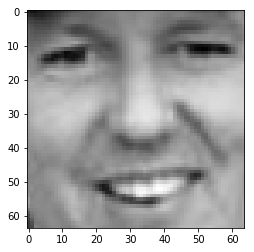

In [31]:
# ... and produce a grayscale image (noting that cmap='gray'
#      is needed to keep matplotlib from showing a colormap)
print(plt.imshow(px2, cmap='gray'))

In [32]:
# Make 2D arrays of all images
count = 0
for obj3 in glob.glob('smiles/*smile*'):
    count+=1
    three = cv2.imread(obj3)
    two = three[:,:,0]
    np.save(obj3 + 'D2', two)
print("total files converted:", count)

total files converted: 1203


In [33]:
# Make the X (feature) array
#  (noting that reshape(-1) is used to pack the individual
#   image arrays into a larger single array of images)
count = 0
xs = []
for obj4 in glob.glob('smiles/*smile*D2*'):
    count+=1
    x = np.load(obj4).reshape(-1)
    xs.append(x)
xsa = np.array(xs)
print("total files converted:", count)

total files converted: 1203


In [34]:
# Make the X array a permanent file, and check its dimensions
os.makedirs('smile/', exist_ok=True)
np.save('smile/smile_X', xsa)
xsa.shape

(1203, 4096)

In [35]:
# Make the y (target) array
count = 0
ys = []
for obj5 in glob.glob('smiles/*smile*D2*'):
    count+=1
    if obj5[7:8] == 'y':
        y = 1
    elif obj5[7:8] == 'n':
        y = 0
    ys.append(y)
ysa = np.array(ys)
print("total files to y:", count)

total files to y: 1203


In [46]:
# Check y array dimensions
ysa.shape

(1203,)

In [40]:
# This needs to be reshaped to give it 
#  two dimensions (same as X array)
ysar=ysa.reshape(1203,1)

In [41]:
# Check it
ysar.shape

(1203, 1)

In [47]:
# Make the y set a permanent file
np.save('smile/smile_y', ysar)

In [2]:
# For easier viewing below, I'll make separate smile
#  and non-smile arrays ...
#
# Starting with an array with X and y together

xsa = np.load('smile/smile_X.npy')
ysar = np.load('smile/smile_y.npy')

x_y = np.concatenate((xsa, ysar), axis=1)
x_y.shape

(1203, 4097)

In [3]:
# ... create the smiling array, then remove the y column
smil = x_y[x_y[:, 4096] == 1]
smil=np.delete(smil, [4096], axis=1)

In [4]:
smil.shape

(600, 4096)

In [5]:
# ... create the non-smiling array, then remove the y column
nosmil = x_y[x_y[:, 4096] == 0]
nosmil=np.delete(nosmil, [4096], axis=1)

In [6]:
nosmil.shape

(603, 4096)

In [7]:
# Since there are 1203 images, it is reasonable to actually
#  review them all to check they've reasonably been labelled
#  smiles and non-smiles
#
# This creates a function to tile multiple images together

def plot_faces(instances, images_per_row=10, **options):
    size = 64
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.gray, **options)
    plt.axis("off")

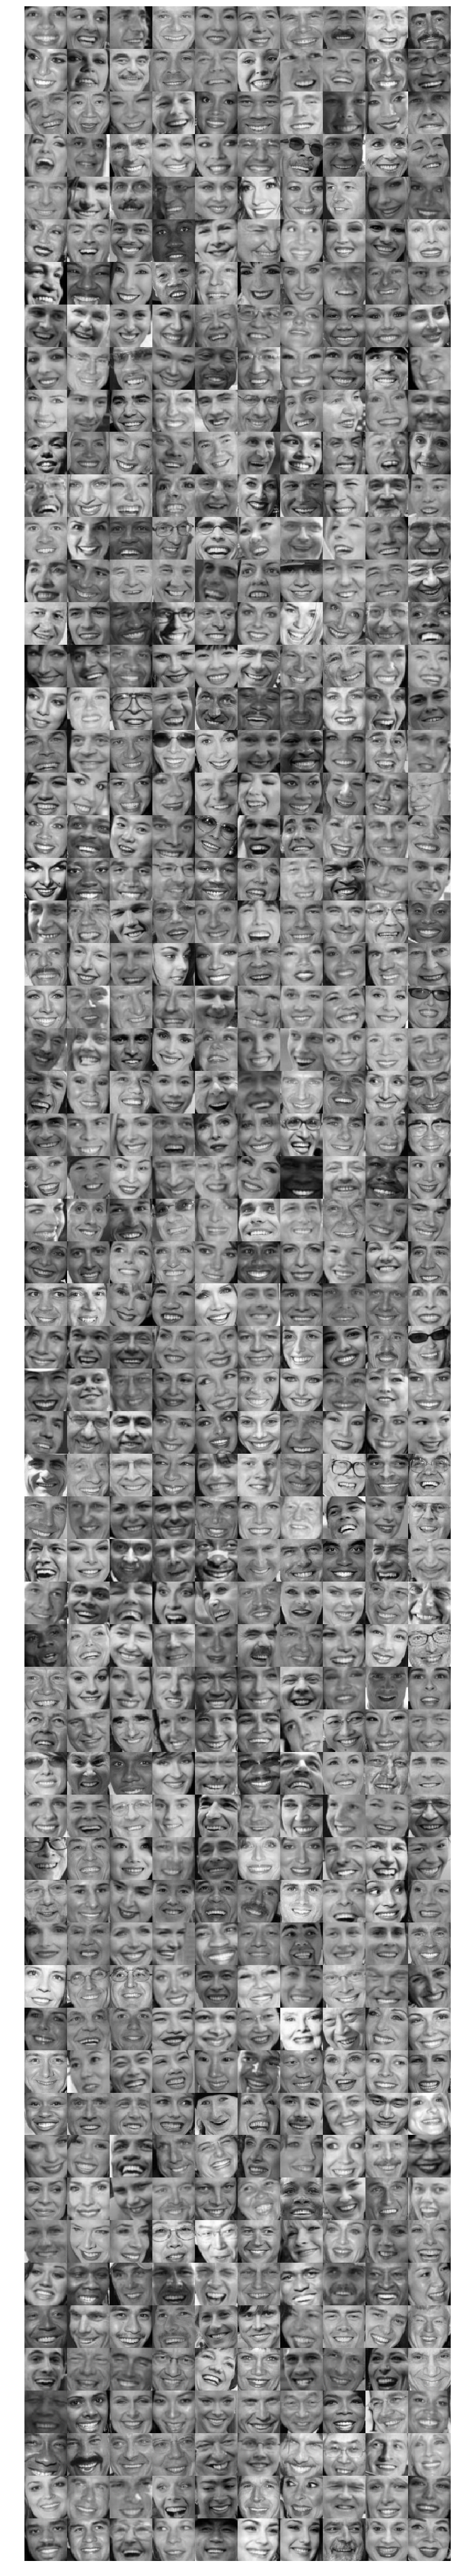

In [8]:
# Review smiles images
plt.figure(figsize=(75,75))
plot_faces(smil, images_per_row=10)
plt.show()

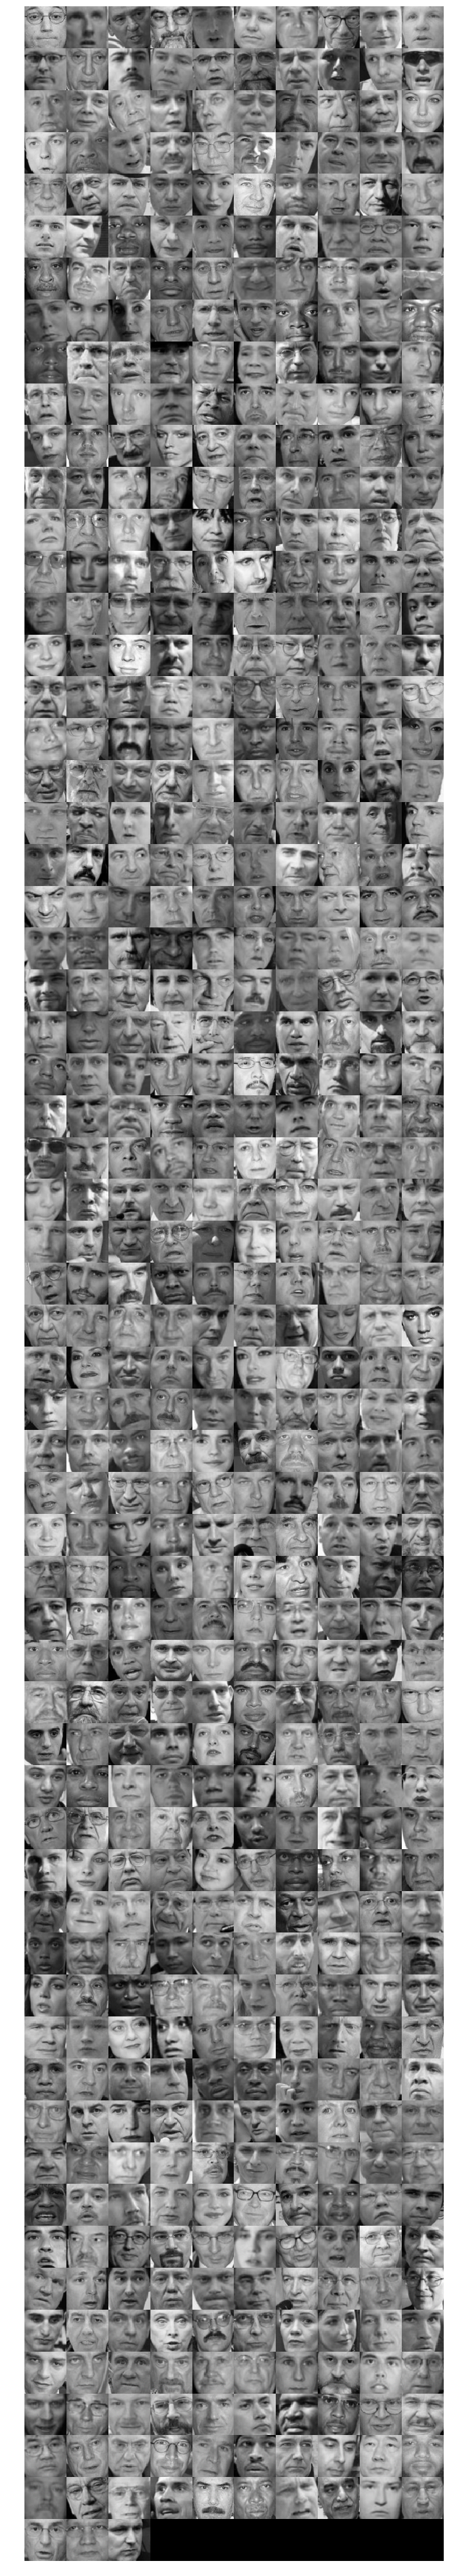

In [9]:
# Review non-smiles images
plt.figure(figsize=(75,75))
plot_faces(nosmil, images_per_row=10)
plt.show()

In [10]:
# Clean up
#  ONLY when ready, remove comment from below 
#shutil.rmtree('smiles/')